# IEEE Fraud v2

This is a starter notebook to help you with the competition submissions. Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Loading libraries

In [1]:
try:
    import xgboost as xgb
except:
    !pip install xgboost
    import xgboost as xgb

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 3.8 MB/s eta 0:00:0000:0100:01


In [2]:
try:
    import pyarrow
except:
    !pip install pyarrow
    import pyarrow

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 14.9 MB/s eta 0:00:0000:0100:01


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
import xgboost as xgb
from operator import itemgetter
import os 
import subprocess 
import smtplib
import logging  

# explicitly require this experimental feature
# from sklearn.experimental import enable_halving_search_cv # noqa

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold

Matplotlib is building the font cache; this may take a moment.


In [208]:
import sklearn
print(sklearn.__version__)

1.2.0


In [4]:
warnings.simplefilter("ignore")

## Begin AML Modelling

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Loading data

### Load train data

In [6]:
train_path__s3 = "s3://pth1/raw-data/"
train_path__vd_local = "C:/kaggle--ieee-fraud-detection--highly-anonymized/"

train_path = train_path__s3

In [7]:
import os
#os.chdir(train_path)

In [8]:
train__txn_file_name = "train_transaction.csv"
train__id_file_name= "train_identity.csv"
test__txn_file_name = "test_transaction.csv"
test__id_file_name= "test_identity.csv"

In [9]:
# Load the Training Data

def get_training_data(train_path, train__txn_file_name, train__id_file_name):
    train_transaction = pd.read_csv(train_path + train__txn_file_name, engine="pyarrow")
    train_identity = pd.read_csv(train_path + train__id_file_name, engine="pyarrow")
    print(f'training Transaction dataset has {train_transaction.shape[0]} rows and {train_transaction.shape[1]} columns.')
    print(f'training Identity dataset has {train_identity.shape[0]} rows and {train_identity.shape[1]} columns.')
    print(train_transaction.info())
    print(train_identity.info())
    return train_transaction, train_identity

In [10]:
%%time

train_transactions, train_identity = get_training_data(train_path, train__txn_file_name, train__id_file_name)
print('Train data set is loaded !')

training Transaction dataset has 590540 rows and 394 columns.
training Identity dataset has 144233 rows and 41 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

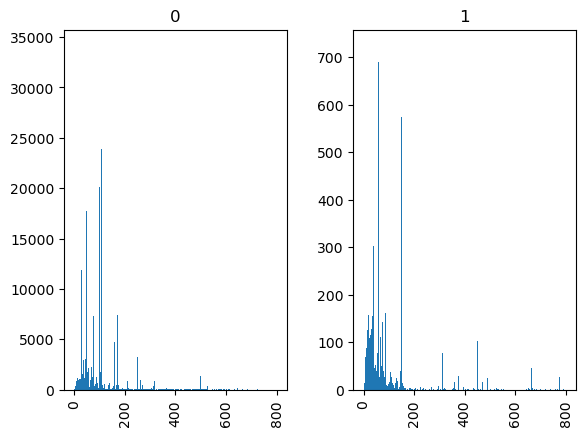

In [11]:
train_transactions.loc[train_transactions.TransactionAmt < 800].hist('TransactionAmt',  by='isFraud', bins = 1000)

In [12]:
train_transactions.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
train_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [14]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,,,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,,,F,F,T,T,desktop,
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


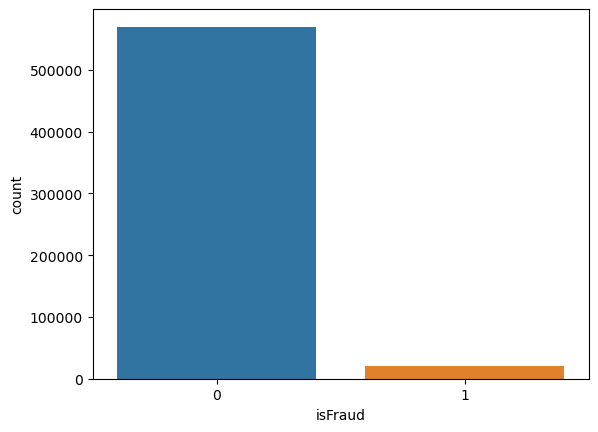

In [15]:
sns.countplot(x=train_transactions["isFraud"]);

- There is clearly a class imbalace problem.

### Merging training data

In [16]:
train_df = train_transactions.merge(train_identity, how="left", on="TransactionID")

print('Train shape',train_df.shape)

print("Data set merged ")

del train_transactions, train_identity

Train shape (590540, 434)
Data set merged 


In [17]:
train_df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [18]:
train_df.shape

(590540, 434)

In [19]:
t_df = train_df[[k for k in train_df.columns if k[0]!='V']]

In [20]:
t_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
t_df[t_df['TransactionID']<3371531]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384526,3371526,0,9647856,91.234,C,15885,545.0,185.0,visa,138.0,...,chrome 64.0,NaN,,,F,F,T,F,desktop,
384527,3371527,0,9647858,20.000,H,12995,520.0,150.0,american express,190.0,...,chrome 64.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows
384528,3371528,1,9647891,250.000,S,9500,321.0,150.0,visa,226.0,...,chrome generic,24.0,855x480,match_status:2,T,F,T,T,mobile,
384529,3371529,0,9647893,63.500,W,12577,268.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
lst = [3371531]
lst.extend(t_df[t_df['TransactionID']<3371531]['TransactionID'].sample(n=4999, random_state=1))
lst[:5]

[3371531, 3344278, 3018290, 3013372, 3128352]

In [23]:
t_df = t_df[t_df.TransactionID.isin(lst)]

In [24]:
data_dir = "s3://pth2/test-dms-data/aml-tm-outputs/"

In [25]:
t_df.to_csv(data_dir + 'overall/all-data--sample-1000.csv', header=True, index=False)

### Reducing training memory usage

In [26]:
%%time
train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
CPU times: user 51.3 s, sys: 1min 5s, total: 1min 56s
Wall time: 1min 57s


In [27]:
train_df['R_emaildomain'].value_counts()

                   453249
gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
                    ...  
netzero.com            14
frontiernet.net        14
centurylink.net        12
netzero.net             9
sc.rr.com               8
Name: R_emaildomain, Length: 61, dtype: int64

### Load test data

In [28]:
# Load the Testing Data

def get_testing_data(train_path, test__txn_file_name, test__id_file_name):
    test_transaction = pd.read_csv(train_path + test__txn_file_name, engine="pyarrow")
    test_identity = pd.read_csv(train_path + test__id_file_name, engine="pyarrow")
    print(f'Testing Transaction dataset has {test_transaction.shape[0]} rows and {test_transaction.shape[1]} columns.')
    print(f'Testing Identity dataset has {test_identity.shape[0]} rows and {test_identity.shape[1]} columns.')
    print(test_transaction.info())
    print(test_identity.info())
    return test_transaction, test_identity

In [29]:
%%time 
     
test_transactions, test_identity = get_testing_data(train_path, test__txn_file_name, test__id_file_name)
print('Test data set is loaded !')

Testing Transaction dataset has 506691 rows and 393 columns.
Testing Identity dataset has 141907 rows and 41 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 393 entries, TransactionID to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.5+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141907 entries, 0 to 141906
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  141907 non-null  int64  
 1   id-01          141907 non-null  float64
 2   id-02          136976 non-null  float64
 3   id-03          66481 non-null   float64
 4   id-04          66481 non-null   float64
 5   id-05          134750 non-null  float64
 6   id-06          134750 non-null  float64
 7   id-07          5059 non-null    float64
 8   id-08          5059 non-null    float64
 9   id-09          74338 non-null   float64
 10  id-10          74338 non-null   fl

### Merging testing data

In [30]:
%%time
test_df = test_transactions.merge(test_identity, how="left", on="TransactionID")

print('Train shape',train_df.shape)

print("Data set merged ")

del test_transactions, test_identity

Train shape (590540, 434)
Data set merged 
CPU times: user 872 ms, sys: 776 ms, total: 1.65 s
Wall time: 1.72 s


### Reducing testing memory usage

In [31]:
%%time
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 565.37 Mb (66.3% reduction)
CPU times: user 32.3 s, sys: 40.5 s, total: 1min 12s
Wall time: 1min 13s


In [32]:
# fix columns names
test_df= test_df.rename(columns=lambda x:"_".join(x.split("-")))

# set TransactionID as index
train_df.set_index('TransactionID', inplace=True)
test_df.set_index('TransactionID', inplace=True)

In [33]:
# Save data to pickle files for faster loading
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')

In [34]:
%%time
# load pickled data
train_df = pd.read_pickle('train_df.pkl')
test_df = pd.read_pickle('test_df.pkl')

CPU times: user 1.22 s, sys: 444 ms, total: 1.67 s
Wall time: 1.75 s


In [35]:
train_df.shape

(590540, 433)

In [36]:
len([k for k in train_df.columns if 'V'==k[0]])

339

In [37]:
cols_to_keep = [k for k in train_df.columns if 'V'!=k[0]]
print(cols_to_keep)

['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [39]:
train_df.shape

(590540, 433)

In [40]:
train_df.columns

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)

In [41]:
import copy
train_df_2 = copy.copy(train_df)
train_df = train_df[[k for k in cols_to_keep if k!='isFraud']]
train_df.shape

(590540, 93)

In [42]:
train_df.columns

Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3',
       'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_01',
       'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09',
       'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17',
       'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

In [43]:
y_train = train_df_2['isFraud']
y_train.shape

(590540,)

In [44]:
test_df_2 = copy.copy(test_df)
test_df = test_df[[col for col in cols_to_keep if col!='isFraud']]
test_df.shape

(506691, 93)

In [45]:
try:
    from treeinterpreter import treeinterpreter as ti
except ImportError:
    !pip install treeinterpreter
    from treeinterpreter import treeinterpreter as ti

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [46]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [47]:
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()

### Replace missing values and use label encoder for categorical variables

In [48]:
%%time
# replace numeric missing values with a mean
for f in train_df.columns:
    if (train_df[f].dtype!='object') and (f!='isFraud'): 
        if (train_df[f].isna().sum()>0) or (test_df[f].isna().sum()>0):
            mean = np.mean(train_df[~(train_df[f].isna())][f].values)  # simple mean on pandas column produces NaNs
            if mean:
                print(f'{f: >10} mean: {mean: >10.3f}, n_train_missing = {train_df[f].isna().sum(): >10,}, n_test_missing = {test_df[f].isna().sum(): >10,}')
                train_df[f] = np.where(train_df[f].isna(), mean, train_df[f])
                test_df[f] = np.where(test_df[f].isna(), mean, test_df[f])

     card2 mean:    362.500, n_train_missing =      8,933, n_test_missing =      8,654
     card3 mean:    153.250, n_train_missing =      1,565, n_test_missing =      3,002
     card5 mean:    199.250, n_train_missing =      4,259, n_test_missing =      4,547
     addr1 mean:    290.750, n_train_missing =     65,706, n_test_missing =     65,609
     addr2 mean:     86.812, n_train_missing =     65,706, n_test_missing =     65,609
     dist1 mean:    118.500, n_train_missing =    352,271, n_test_missing =    291,217
     dist2 mean:    231.875, n_train_missing =    552,913, n_test_missing =    470,255
        C1 mean:     14.094, n_train_missing =          0, n_test_missing =          3
        C2 mean:     15.273, n_train_missing =          0, n_test_missing =          3
        C3 mean:      0.006, n_train_missing =          0, n_test_missing =          3
        C4 mean:      4.094, n_train_missing =          0, n_test_missing =          3
        C5 mean:      5.570, n_train_missin

In [49]:
train_df['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [50]:
train_df['id_38'].value_counts()

F    73922
T    67063
      3248
Name: id_38, dtype: int64

In [51]:
# All categorical columns
object_cols = [col for col in train_df.columns if train_df[col].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(train_df[col]) == set(test_df[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols =  list (set(object_cols) - set(good_label_cols))
        
print('Categorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be label encoded: ['ProductCD', 'card4', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

Categorical columns that will be dropped from the dataset: ['id_35', 'id_23', 'DeviceInfo', 'id_33', 'id_27', 'P_emaildomain', 'id_36', 'card6', 'id_37', 'id_38', 'id_30', 'id_12', 'id_28', 'id_16', 'DeviceType', 'id_15', 'id_29', 'id_34', 'id_31']


In [52]:
%%time

# Replace remaining missing values with -999
train_df = train_df.fillna(-999)
test_df = test_df.fillna(-999)

CPU times: user 4.59 s, sys: 31.7 ms, total: 4.62 s
Wall time: 4.61 s


In [53]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: train_df[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: -x[1])

[('DeviceInfo', 1788),
 ('id_33', 262),
 ('id_31', 132),
 ('id_30', 77),
 ('R_emaildomain', 61),
 ('P_emaildomain', 60),
 ('id_34', 6),
 ('ProductCD', 5),
 ('card4', 5),
 ('card6', 5),
 ('id_15', 5),
 ('id_23', 5),
 ('M4', 4),
 ('id_16', 4),
 ('id_27', 4),
 ('id_28', 4),
 ('id_29', 4),
 ('id_35', 4),
 ('id_36', 4),
 ('id_37', 4),
 ('id_38', 4),
 ('DeviceType', 4),
 ('M1', 3),
 ('M2', 3),
 ('M3', 3),
 ('M5', 3),
 ('M6', 3),
 ('M7', 3),
 ('M8', 3),
 ('M9', 3),
 ('id_12', 3)]

In [54]:
train_df.drop(bad_label_cols, axis=1, inplace=True)
test_df.drop(bad_label_cols, axis=1, inplace=True)

In [55]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in good_label_cols if train_df[col].nunique() < 10]

# Columns that will be label encoded
high_cardinality_cols = list(set(good_label_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be label encoded:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['ProductCD', 'card4', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

Categorical columns that will be label encoded: ['R_emaildomain']


In [56]:
%%time

# Label Encoding for categorical features
for f in high_cardinality_cols: 
    lbl_enc = LabelEncoder()
    lbl_enc.fit(list(train_df[f].values))
    print(f'{f}: {lbl_enc.classes_}')
    train_df[f] = lbl_enc.transform(list(train_df[f].values))
    test_df[f] = lbl_enc.transform(list(test_df[f].values))

R_emaildomain: ['' 'aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'scranton.edu' 'servicios-ta.com' 'suddenlink.net' 'twc.com'
 'verizon.net' 'web.de' 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk'
 'yahoo.com' 'yahoo.com.mx' 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com']
CPU times: user 821 ms, sys: 3.82 ms, total: 825 ms
Wall time: 821 ms


In [57]:
train_df[low_cardinality_cols].head()

,ProductCD,card4,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,
2987000,W,discover,T,T,T,M2,F,T,,,
2987001,W,mastercard,,,,M0,T,T,,,
2987002,W,visa,T,T,T,M0,F,F,F,F,F
2987003,W,mastercard,,,,M0,T,F,,,
2987004,H,mastercard,,,,,,,,,


In [58]:
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(drop='first', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_df[low_cardinality_cols].astype('str')))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(test_df[low_cardinality_cols].astype('str')))

# One-hot encoding removed index; put it back
OH_cols_train.index = train_df.index
OH_cols_valid.index = test_df.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = train_df.drop(low_cardinality_cols, axis=1)
num_X_valid = test_df.drop(low_cardinality_cols, axis=1)

del train_df, test_df

# Add one-hot encoded columns to numerical features
OH_train_df = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_test_df = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [59]:
del num_X_train, OH_cols_train, num_X_valid, OH_cols_valid

- We will now split the train dataset into train and validation sets (20% of data for validation)

In [60]:
OH_train_df.columns

Index([ 'TransactionDT', 'TransactionAmt',          'card1',          'card2',
                'card3',          'card5',          'addr1',          'addr2',
                'dist1',          'dist2',  'R_emaildomain',             'C1',
                   'C2',             'C3',             'C4',             'C5',
                   'C6',             'C7',             'C8',             'C9',
                  'C10',            'C11',            'C12',            'C13',
                  'C14',             'D1',             'D2',             'D3',
                   'D4',             'D5',             'D6',             'D7',
                   'D8',             'D9',            'D10',            'D11',
                  'D12',            'D13',            'D14',            'D15',
                'id_01',          'id_02',          'id_03',          'id_04',
                'id_05',          'id_06',          'id_07',          'id_08',
                'id_09',          'id_10',          

In [61]:
y_train.shape

(590540,)

In [62]:
OH_train_df.shape

(590540, 90)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(OH_train_df, y_train.astype('uint8'), test_size=.1, random_state=42, stratify=y_train.astype('uint8'))

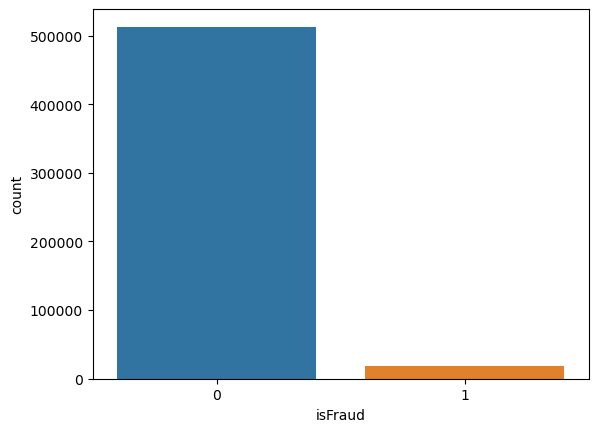

In [64]:
sns.countplot(x = y_train);

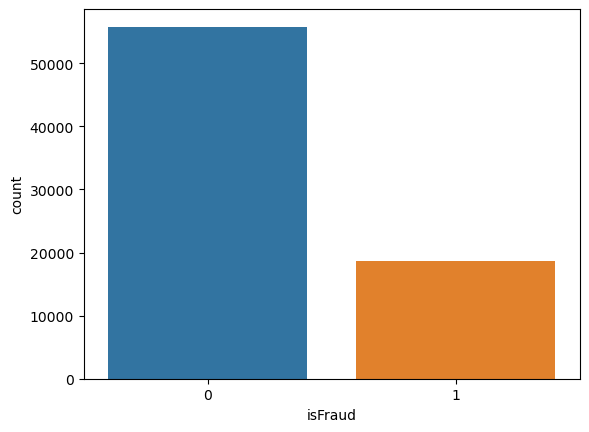

In [65]:
# Downsample majority class
df_majority_downsampled, y_majority_downsampled = resample(
    X_train[y_train == 0], 
    y_train[y_train == 0],
    replace=False,    # sample with replacement
    n_samples=3*len(y_train[y_train == 1]),   
    random_state=42)  # reproducible results

X_down_train = pd.concat([X_train[y_train == 1], df_majority_downsampled])
# print(X_down_train.shape)

y_down_train = pd.concat([y_train[y_train == 1], y_majority_downsampled])
# y_down_train.value_counts()

sns.countplot(x = y_down_train);

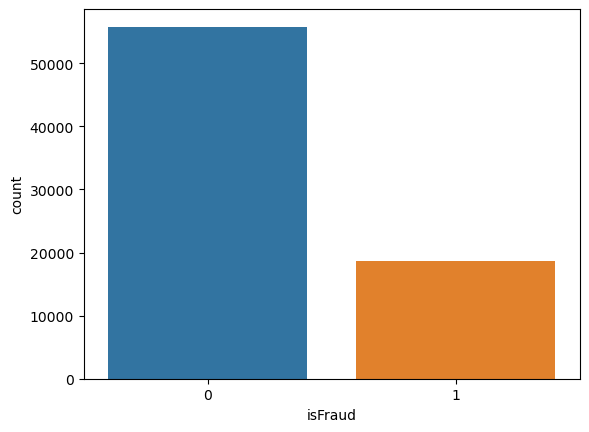

In [66]:
X_train_sm, y_train_sm = X_down_train, y_down_train

# # # Upsample minority class with Smote variant
# from imblearn.over_sampling import SMOTE
# # from imblearn.combine import SMOTETomek
# # from imblearn.combine import SMOTEENN
# smt = SMOTE(random_state=42)
# # smt = SMOTETomek(random_state=42)
# # smt = SMOTEENN(random_state=42)
# X_train_sm, y_train_sm = smt.fit_resample(X_down_train, y_down_train)

sns.countplot(x = y_train_sm);

## Fit the model

In [67]:
X_train_sm.columns = [str(col) for col in X_train_sm.columns]

In [68]:
X_train_sm.columns

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist1', 'dist2', 'R_emaildomain', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
       'D12', 'D13', 'D14', 'D15', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05',
       'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25',
       'id_26', 'id_32', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26'],
      dtype='object')

In [69]:
clf_rf_down = RandomForestClassifier(random_state=42, n_estimators=50)
model_rf_down = clf_rf_down.fit(X_train_sm, y_train_sm)

In [70]:
X_test.columns = [str(col) for col in X_test.columns]

In [71]:
y_test.value_counts()

0    56988
1     2066
Name: isFraud, dtype: int64

In [72]:
y_pred = model_rf_down.predict(X_test)

In [73]:
y_prob = model_rf_down.predict_proba(X_test)[:, 1]
y_prob__dummy = len(y_test[y_test==1]) / len(y_test)

In [74]:
y_prob

array([0.1 , 0.06, 0.04, ..., 0.2 , 0.14, 0.12])

In [75]:
#explainer = shap.TreeExplainer(model_rf_down)

In [76]:
#import shap
#shap.initjs()
#rf_shap_values = shap.KernelExplainer(model_rf_down.predict,X_test)

In [77]:
#rf_explainer = shap.KernelExplainer(model_rf_down.predict,X_test)
#rf_shap_values = rf_explainer.shap_values(X_test, nsamples=100)
#shap.summary_plot(rf_shap_values, X_test)

## Model Evaluation & Performance Metrics

In [78]:
rf__acc = accuracy_score(y_test, y_pred)
rf__roc_auc = roc_auc_score(y_test, y_prob)
rf__conf_matrx = confusion_matrix(y_test, y_pred)

In [79]:
print(f"Accuracy score = {rf__acc:.3f}")
print(f'ROC-AUC score: {rf__roc_auc:.3f}')

Accuracy score = 0.971
ROC-AUC score: 0.939


In [80]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     56988
           1       0.57      0.72      0.64      2066

    accuracy                           0.97     59054
   macro avg       0.78      0.85      0.81     59054
weighted avg       0.98      0.97      0.97     59054



In [81]:
cr = classification_report(y_test,y_pred, output_dict=True)

In [82]:
rf__1_recall_df = pd.DataFrame([cr['1']['recall']*100], columns=['Recall-class-1'])
rf__1_precision_df = pd.DataFrame([cr['1']['precision']*100], columns=['Precision-class-1'])

In [83]:
TN = rf__conf_matrx[0][0]
FN = rf__conf_matrx[1][0]
TP = rf__conf_matrx[1][1]
FP = rf__conf_matrx[0][1]

In [84]:
rf__precision, rf__recall, rf__thresholds = precision_recall_curve(y_test, y_prob)
#rf__precision, rf__recall, rf__thresholds = precision_recall_curve(y_test, y_prob)

In [85]:
rf__auc_score = auc(rf__recall, rf__precision)
rf__auc_score

0.7186716965047146

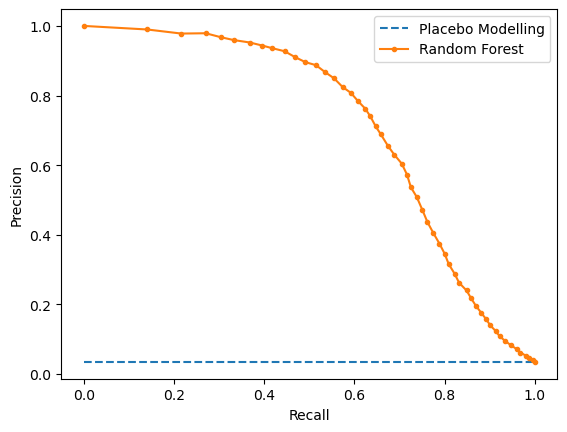

In [86]:
plt.plot([0, 1], [y_prob__dummy, y_prob__dummy], linestyle='--', label='Placebo Modelling')
plt.plot(rf__recall, rf__precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

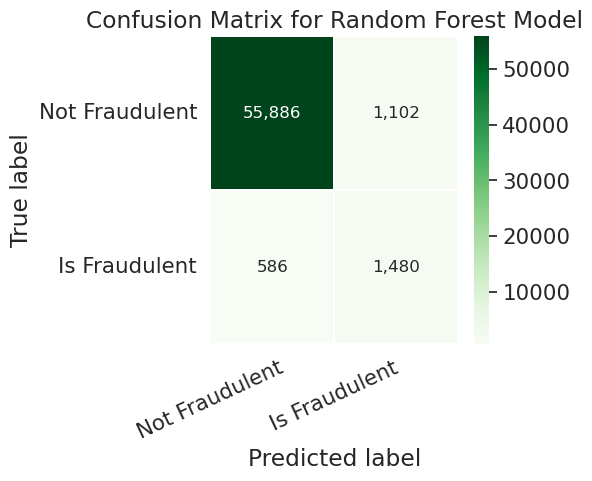

In [87]:
# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(rf__conf_matrx, annot=True, annot_kws={'size':12},fmt=',d', cmap=plt.cm.Greens, linewidths=0.2)
class_names = ['Not Fraudulent', 'Is Fraudulent']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [88]:
rf__features_df = pd.DataFrame({'features': model_rf_down.feature_names_in_, 'importance': model_rf_down.feature_importances_ })

In [89]:
rf__features_df['importance'] = rf__features_df.importance.apply(lambda x: round(x,4))

In [90]:
rf__features_df_sorted = rf__features_df.sort_values(by='importance', ascending=False)
rf__features_df_sorted

,features,importance
1,TransactionAmt,0.0467
23,C13,0.0454
0,TransactionDT,0.0450
11,C1,0.0402
2,card1,0.0391
...,...,...
61,id_26,0.0004
59,id_24,0.0003
58,id_22,0.0002
13,C3,0.0001


In [91]:
def get_normalized(inp_df, column):
    norm_imp = 100*(inp_df[column] - inp_df[column].min()) / (inp_df[column].max() - inp_df[column].min())
    inp_df_2 = inp_df.assign(Normalized=norm_imp)
    col_name = "Normalized_"+column
    inp_df_2 = inp_df_2.rename(columns={'Normalized':col_name})
    inp_df_2 = inp_df_2.sort_values(by=col_name, ascending=False)
    return inp_df_2

In [92]:
rf__features_df_norm =get_normalized(inp_df = rf__features_df_sorted, column = 'importance')

In [93]:
rf__features_df_norm

,features,importance,Normalized_importance
1,TransactionAmt,0.0467,100.000000
23,C13,0.0454,97.216274
0,TransactionDT,0.0450,96.359743
11,C1,0.0402,86.081370
2,card1,0.0391,83.725910
...,...,...,...
61,id_26,0.0004,0.856531
59,id_24,0.0003,0.642398
58,id_22,0.0002,0.428266
13,C3,0.0001,0.214133


In [94]:
final_feature_imp = rf__features_df_norm[:10]

In [95]:
final_feature_imp

,features,importance,Normalized_importance
1,TransactionAmt,0.0467,100.000000
23,C13,0.0454,97.216274
0,TransactionDT,0.0450,96.359743
11,C1,0.0402,86.081370
2,card1,0.0391,83.725910
24,C14,0.0366,78.372591
3,card2,0.0351,75.160600
26,D2,0.0327,70.021413
6,addr1,0.0310,66.381156
27,D3,0.0290,62.098501


In [96]:
final_feature_imp

,features,importance,Normalized_importance
1,TransactionAmt,0.0467,100.000000
23,C13,0.0454,97.216274
0,TransactionDT,0.0450,96.359743
11,C1,0.0402,86.081370
2,card1,0.0391,83.725910
24,C14,0.0366,78.372591
3,card2,0.0351,75.160600
26,D2,0.0327,70.021413
6,addr1,0.0310,66.381156
27,D3,0.0290,62.098501


## Store the Model for downstream use (hosting, inferencing)

In [411]:
import joblib
joblib.__version__

'1.2.0'

In [412]:
s3 = boto3.resource('s3')
bucket_name = "asean-deltalake--raw"
key = "rf_model.pkl"
OutputFile = bucket_name + key
print(joblib.__version__)

# WRITE
pickle.dump(model_rf_down, open(key, 'wb'))
#s3 = boto3.resource('s3')
#my_pickle = pickle.loads(s3.Bucket(bucket_name).Object(key).get()['Body'].read())
pickle_byte_obj = pickle.dumps(model_rf_down)
s3.Object(bucket_name,key).put(Body=pickle_byte_obj)

1.2.0


{'ResponseMetadata': {'RequestId': 'FHHRYQWJNGY9Z4BK',
  'HostId': '7KOOFFUWZ4+Pvj3LyHe0JO6OL3h+rSgg/V68mehCwSq+/8OzBC3nM3dnNMJEkxMWlzooqnckhJYJrXx6QwRCsQ==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '7KOOFFUWZ4+Pvj3LyHe0JO6OL3h+rSgg/V68mehCwSq+/8OzBC3nM3dnNMJEkxMWlzooqnckhJYJrXx6QwRCsQ==',
   'x-amz-request-id': 'FHHRYQWJNGY9Z4BK',
   'date': 'Tue, 18 Apr 2023 13:01:27 GMT',
   'x-amz-version-id': '.IsTEjlWeeD06dlk4IexzU0GYgeHNM8a',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"5d9e0cc3bf9bb0b195aef56364146d5b"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"5d9e0cc3bf9bb0b195aef56364146d5b"',
 'ServerSideEncryption': 'AES256',
 'VersionId': '.IsTEjlWeeD06dlk4IexzU0GYgeHNM8a'}

In [413]:
if False:
    with tempfile.TemporaryFile() as fp:
        joblib.dump(model_rf_down, fp)
        fp.seek(0)
        s3.put_object(Bucket = bucket_name, Key = key, Body=fp.read())

In [414]:
%%writefile inference.py

import os
os.system("pip uninstall joblib --yes")
os.system("pip install joblib")

import joblib
import json
import pickle
import tempfile
import boto3
from io import BytesIO
#from sklearn.externals import joblib

s3 = boto3.resource('s3')
bucket_name = "asean-deltalake--raw"
bucket_key = "rf_model.pkl"
OutputFile = bucket_name + bucket_key


"""
Deserialize fitted model
"""
def model_fn(model_dir):
    model = pickle.loads(s3.Bucket(bucket_name).Object(bucket_key).get()['Body'].read())
    return model

"""
input_fn
    request_body: The body of the request sent to the model.
    request_content_type: (string) specifies the format/variable type of the request
"""
def input_fn(request_body, request_content_type):
    if request_content_type == 'application/json':
        request_body = json.loads(request_body)
        inpVar = request_body['Input']
        return inpVar
    else:
        raise ValueError("This model only supports application/json input")

"""
predict_fn
    input_data: returned array from input_fn above
    model (sklearn model) returned model loaded from model_fn above
"""
def predict_fn(input_data, model):
    print(joblib.__version__)
    print(type(input_data))
    print(input_data)
    print(model)
    print(type(model))
    return model.predict(input_data)

"""
output_fn
    prediction: the returned value from predict_fn above
    content_type: the content type the endpoint expects to be returned. Ex: JSON, string
"""

def output_fn(prediction, content_type):
    res = int(prediction[0])
    respJSON = {'Output': res}
    return respJSON

Overwriting inference.py


## EXECUTE MAIN.PY IN IPYNB

In [415]:
import boto3
import json
import os
import joblib
import pickle
import tarfile
import sagemaker
from sagemaker.estimator import Estimator
import time
from time import gmtime, strftime
import subprocess

In [416]:
#Setup
client = boto3.client(service_name="sagemaker")
runtime = boto3.client(service_name="sagemaker-runtime")
boto_session = boto3.session.Session()
s3 = boto_session.resource('s3')
region = boto_session.region_name
print(region)
sagemaker_session = sagemaker.Session()
role = "arn:aws:iam:role/sagemaker--s3-ecr--custom-model-deployment"

ap-southeast-1


In [417]:
#Build tar file with model data + inference code
bashCommand = "tar -cvpzf model.tar.gz rf_model.pkl inference.py"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
print(error)

# retrieve sklearn image
image_uri = sagemaker.image_uris.retrieve(
    framework="sklearn",
    region=region,
    version="0.23-1",
    py_version="py3",
    instance_type="ml.m5.xlarge",
)

#Bucket for model artifacts
default_bucket = bucket_name
OutputFile = bucket_name
print(OutputFile)

#Upload tar.gz to bucket
model_artifacts = f"s3://{OutputFile}/model.tar.gz"
response = s3.meta.client.upload_file('model.tar.gz', OutputFile, 'model.tar.gz')
print(response)

None
asean-deltalake--raw
None


In [418]:
#Step 1: Model Creation
model_name = "sklearn--rf-classifier-fraud--" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: " + model_name)
create_model_response = client.create_model(
    ModelName=model_name,
    Containers=[
        {
            "Image": image_uri,
            "Mode": "SingleModel",
            "ModelDataUrl": model_artifacts,
            "Environment": {'SAGEMAKER_SUBMIT_DIRECTORY': model_artifacts,
                           'SAGEMAKER_PROGRAM': 'inference.py'} 
        }
    ],
    ExecutionRoleArn=role,
)
print("Model Arn: " + create_model_response["ModelArn"])

Model name: sklearn--rf-classifier-fraud--2023-04-18-13-02-06
Model Arn: arn:aws:sagemaker:ap-southeast-1:329193457145:model/sklearn--rf-classifier-fraud--2023-04-18-13-02-06


In [419]:
#Step 2: EPC Creation
sklearn_epc_name = "sklearn-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=sklearn_epc_name,
    ProductionVariants=[
        {
            "VariantName": "sklearnvariant",
            "ModelName": model_name,
            "InstanceType": "ml.c5.large",
            "InitialInstanceCount": 1
        },
    ],
)
print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:ap-southeast-1:329193457145:endpoint-config/sklearn-epc2023-04-18-13-02-07


In [420]:
#Step 3: EP Creation
endpoint_name = "rf-classifier--ep-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=sklearn_epc_name,
)
print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:ap-southeast-1:329193457145:endpoint/rf-classifier--ep-2023-04-18-13-02-07


In [421]:
#Monitor creation
i=1
describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
    print(describe_endpoint_response["EndpointStatus"] + str(i))
    i=i+1
    time.sleep(15)
print(describe_endpoint_response)

Creating1
Creating2
Creating3
Creating4
Creating5
Creating6
Creating7
Creating8
Creating9
Creating10
InService11
{'EndpointName': 'rf-classifier--ep-2023-04-18-13-02-07', 'EndpointArn': 'arn:aws:sagemaker:ap-southeast-1:329193457145:endpoint/rf-classifier--ep-2023-04-18-13-02-07', 'EndpointConfigName': 'sklearn-epc2023-04-18-13-02-07', 'ProductionVariants': [{'VariantName': 'sklearnvariant', 'DeployedImages': [{'SpecifiedImage': '121021644041.dkr.ecr.ap-southeast-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3', 'ResolvedImage': '121021644041.dkr.ecr.ap-southeast-1.amazonaws.com/sagemaker-scikit-learn@sha256:387f1fac72b3e95b58c719dd0ffdfec71c450795bfbfbce9a8a4de9da6affd37', 'ResolutionTime': datetime.datetime(2023, 4, 18, 13, 2, 8, 310000, tzinfo=tzlocal())}], 'CurrentWeight': 1.0, 'DesiredWeight': 1.0, 'CurrentInstanceCount': 1, 'DesiredInstanceCount': 1}], 'EndpointStatus': 'InService', 'CreationTime': datetime.datetime(2023, 4, 18, 13, 2, 7, 749000, tzinfo=tzlocal()), 'LastMod

## INVOKE.PY

In [422]:
import boto3
import json

In [423]:
X_train_sm.iloc[0]

TransactionDT     3.437243e+06
TransactionAmt    2.885938e+01
card1             4.504000e+03
card2             5.000000e+02
card3             1.850000e+02
                      ...     
22                0.000000e+00
23                0.000000e+00
24                0.000000e+00
25                0.000000e+00
26                0.000000e+00
Name: 3149236, Length: 90, dtype: float64

In [424]:
y_test

TransactionID
3038022    0
3368984    0
3041504    0
3086348    0
2990012    0
          ..
3318249    0
3005021    0
3465609    0
3361749    0
3134508    0
Name: isFraud, Length: 59054, dtype: uint8

In [425]:
list(X_test.iloc[0])

[1202215.0,
 171.0,
 15497.0,
 490.0,
 150.0,
 226.0,
 299.0,
 87.0,
 118.5,
 231.875,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 169.625,
 28.34375,
 0.0,
 42.34375,
 69.8125,
 41.625,
 146.0,
 0.56103515625,
 0.0,
 146.625,
 54.03125,
 17.90625,
 57.71875,
 0.0,
 -10.171875,
 174716.59375,
 0.0601806640625,
 -0.058929443359375,
 1.615234375,
 -6.69921875,
 13.2890625,
 -38.59375,
 0.09100341796875,
 -0.301025390625,
 99.75,
 48.0625,
 -344.5,
 189.5,
 14.234375,
 353.25,
 404.0,
 368.25,
 16.0,
 12.8046875,
 329.5,
 149.125,
 26.515625,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [426]:
runtime_client = boto3.client('sagemaker-runtime')
content_type = "application/json"
request_body = {"Input": [list(X_test.iloc[0])]}
data = json.loads(json.dumps(request_body))
payload = json.dumps(data)
endpoint_name = "rf-classifier"

In [428]:
payload

'{"Input": [[1202215.0, 171.0, 15497.0, 490.0, 150.0, 226.0, 299.0, 87.0, 118.5, 231.875, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 169.625, 28.34375, 0.0, 42.34375, 69.8125, 41.625, 146.0, 0.56103515625, 0.0, 146.625, 54.03125, 17.90625, 57.71875, 0.0, -10.171875, 174716.59375, 0.0601806640625, -0.058929443359375, 1.615234375, -6.69921875, 13.2890625, -38.59375, 0.09100341796875, -0.301025390625, 99.75, 48.0625, -344.5, 189.5, 14.234375, 353.25, 404.0, 368.25, 16.0, 12.8046875, 329.5, 149.125, 26.515625, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}'

In [ ]:
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType=content_type,
    Body=payload)
result = json.loads(response['Body'].read().decode())['Output']